In [18]:
import json
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import datetime
from numpy import array

import numpy as np
import pandas as pd
import re
import warnings

#Visualisation
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from IPython.display import display
from wordcloud import WordCloud, STOPWORDS

#nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
from nltk import tokenize

matplotlib.style.use('ggplot')
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer
import spacy
import string
from langdetect import detect

In [2]:
# Load in data

print('Loading first month... ')
may_jun = pd.read_json('may_jun19.json')
print('Loading second month... ')
jun_jul = pd.read_json('jun_jul19.json')
print('Loading third month... ')
jul_aug = pd.read_json('jul_aug19.json')

# Due to missing data seperate days were scraped again
print('Loading add. days... ')
jun26 = pd.read_json('jun26.json')

jul2 = pd.read_json('jul2.json')
jul68 = pd.read_json('jul6_9.json')
jul9 = pd.read_json('jul9.json')
jul12 = pd.read_json('jul12.json')
jul1416 = pd.read_json('jul14_16.json')
jul18 = pd.read_json('jul18.json')
jul2023 = pd.read_json('jul20_24.json')
jul2526 = pd.read_json('jul25_26.json')
jul81 = pd.read_json('jul81.json')

print('Concat datasets... ')
frame = [may_jun, jun_jul, jul_aug, jun26, jul2, jul68, jul9, jul12, jul1416, jul18, jul2023, jul2526, jul81]
data = pd.concat(frame)

Loading first month... 
Loading second month... 
Loading third month... 
Loading add. days... 
Concat datasets... 


In [3]:
# Check if data is comprehensive
hour_check = data.groupby(pd.Grouper(key='timestamp', freq= '1h')).sum().sort_values('likes')

hour_check[hour_check['likes'] ==0]


,is_retweet,likes,replies,retweets,tweet_id,user_id
timestamp,,,,,,


In [4]:
len(data)
print(len(list(data['tweet_id'])))
print(len(set(list(data['tweet_id']))))

3167428
3061746


# Building functions for data cleaning

In [5]:
def remove_duplicate_tweets(df):
    a = len(list(df['tweet_id']))
    b = len(set(list(df['tweet_id'])))
    
    print('Duplicate tweets to remove: ' + str(a-b) )
    df = df.drop_duplicates(['tweet_id']).reset_index()
    return df

In [6]:
def drop_cols(data):
    try:
        data = data.drop(['fullname', 'html', 'retweet_id', 'retweeter_userid', 'retweeter_username', 'timestamp_epochs', 'tweet_url', 'tweet_id', 'user_id'], axis=1)
    except:
        pass
    #print(data.head())
    return data

In [7]:
# Look at who made the most tweets
print('Computing most tweets per username...')
most_tweets = data.groupby('username').count().sort_values('text', ascending = False)['likes']
print(pd.DataFrame(most_tweets.head(10)))

# fav summing
#data[data['likes']>2]
print('Computing most likes per username...')
most_likes = data.groupby('username').agg('sum').sort_values('likes', ascending = False)['likes']
print(most_likes.head(10))


print('Computing most retweets per username...')
most_retweets = data.groupby('username').agg('sum').sort_values('retweets', ascending = False)['retweets']
print(most_retweets.head(10))


Computing most tweets per username...
                 likes
username              
webnowcompany    21053
CoinCapsAi       20614
vinmaxinfotech   19983
WorkInRobotics   16886
robostopia       15820
bitcoinagile     15648
crypto__mak      15092
Remi_Vladuceanu  12048
coinok           11856
workwithai       11003
Computing most likes per username...
username
APompliano         635208.0
BitCoin_Invest_    180648.0
TheCryptoDog       144718.0
chrissyteigen      101214.0
CCNMarkets          97437.0
BTC_Macro           93044.0
Josh_Rager          86333.0
maxkeiser           85702.0
MoonOverlord        79436.0
cz_binance          75833.0
Name: likes, dtype: float64
Computing most retweets per username...
username
APompliano         117347.0
CCNMarkets          34779.0
CashApp             34620.0
coindesk            26621.0
Cointelegraph       25724.0
cryptoadventura     22635.0
BitCoin_Invest_     20754.0
authpaper           19241.0
maxkeiser           18903.0
TheCryptoDog        18279.0
Nam

In [8]:
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import PorterStemmer # or LancasterStemmer, RegexpStemmer, SnowballStemmer
from nltk.stem import WordNetLemmatizer

default_stemmer = PorterStemmer()

punc = [i for i in string.punctuation if i is not '!']
punc = [i for i in punc if i is not '?']
punc = ''.join(punc)

def lower_case(data):
    words = data.lower()
    return words

def remove_links(data):
    '''
    Removes @usernames and http / https links and .co adresses
    
    for .co |(\S+?\.co?\S)
    '''
    regex = r'(@[A-Za-z0-9]+)|(?i)\b((?:https?:(?:/{1,3}|[a-z0-9%])|[a-z0-9.\-]+[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)/)(?:[^\s()<>{}\[\]]+|\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\))+(?:\([^\s()]*?\([^\s()]+\)[^\s()]*?\)|\([^\s]+?\)|[^\s`!()\[\]{};:\'\".,<>?«»“”‘’])|(?:(?<!@)[a-z0-9]+(?:[.\-][a-z0-9]+)*[.](?:com|net|org|edu|gov|mil|aero|asia|biz|cat|coop|info|int|jobs|mobi|museum|name|post|pro|tel|travel|xxx|ac|ad|ae|af|ag|ai|al|am|an|ao|aq|ar|as|at|au|aw|ax|az|ba|bb|bd|be|bf|bg|bh|bi|bj|bm|bn|bo|br|bs|bt|bv|bw|by|bz|ca|cc|cd|cf|cg|ch|ci|ck|cl|cm|cn|co|cr|cs|cu|cv|cx|cy|cz|dd|de|dj|dk|dm|do|dz|ec|ee|eg|eh|er|es|et|eu|fi|fj|fk|fm|fo|fr|ga|gb|gd|ge|gf|gg|gh|gi|gl|gm|gn|gp|gq|gr|gs|gt|gu|gw|gy|hk|hm|hn|hr|ht|hu|id|ie|il|im|in|io|iq|ir|is|it|je|jm|jo|jp|ke|kg|kh|ki|km|kn|kp|kr|kw|ky|kz|la|lb|lc|li|lk|lr|ls|lt|lu|lv|ly|ma|mc|md|me|mg|mh|mk|ml|mm|mn|mo|mp|mq|mr|ms|mt|mu|mv|mw|mx|my|mz|na|nc|ne|nf|ng|ni|nl|no|np|nr|nu|nz|om|pa|pe|pf|pg|ph|pk|pl|pm|pn|pr|ps|pt|pw|py|qa|re|ro|rs|ru|rw|sa|sb|sc|sd|se|sg|sh|si|sj|Ja|sk|sl|sm|sn|so|sr|ss|st|su|sv|sx|sy|sz|tc|td|tf|tg|th|tj|tk|tl|tm|tn|to|tp|tr|tt|tv|tw|tz|ua|ug|uk|us|uy|uz|va|vc|ve|vg|vi|vn|vu|wf|ws|ye|yt|yu|za|zm|zw)\b/?(?!@)))'
    new_text = []
    for i, v in enumerate(data):      
        if re.match(regex, data[i]) is None:
            new_text.append(v)
    return new_text

def remove_hashtags(data):
    #tokens = WhitespaceTokenizer().tokenize(data)
    for i, v in enumerate(data):      
        if re.match(r"([^0-9A-Za-z \t | ! | ?] )", data[i]) is not None:
            data[i] = re.sub(r"([^0-9A-Za-z \t | ! | ?])", "", v)
    return data

def remove_special_characters(text, characters=punc):
    pattern = re.compile('[{}]'.format(re.escape(characters)))
    return filter(None, [pattern.sub('', t) for t in text])

def stem_text(data, stemmer = default_stemmer):
    stemmed = [stemmer.stem(t) for t in data]
    return stemmed

def nltk_lemma(data):
    lemmatizer = WordNetLemmatizer()
    clean = []
    for word in data:
        clean.append(lemmatizer.lemmatize(word, pos="n"))
    return clean   

def spacy_lemma(text):
    clean = []
    for word in text:
        nlp = spacy.load('en', disable=['parser', 'ner'])
        doc = nlp(word)
        clean.append(" ".join([token.lemma_ for token in doc]))
    return clean

def remove_numbers(data):
    clean = []
    for word in data:   
        word = re.sub("\d+", '', word)
        clean.append(word)
    return clean

def remove_stopwords(data):
    stopword_set = set(stopwords.words("english"))
    meaningful_words = [w for w in data if w not in stopword_set]
    return meaningful_words    
    
def process(tweet_series):
    tweets_df = tweet_series

    num_tweets = tweets_df.shape[0]
    print("Total tweets: " + str(num_tweets))

    cleaned_tweets = []
    
    start = datetime.datetime.now()
    print("Beginning processing of tweets at: " + str(start))

    for i in range(num_tweets):
        cleaned_tweet = pipe(tweets_df.loc[i]['text'])
        cleaned_tweets.append(cleaned_tweet)
        if(i % 10000 == 0):
            print(str(i) + " tweets processed")
    
    end = datetime.datetime.now()
    print("Finished processing of tweets at: " + str(end))
    print("Processing Time: " + str(end - start))
    return cleaned_tweets

def pipe(tweet):
    # tokenize data
    tokens = WhitespaceTokenizer().tokenize(tweet)
    temp = tokens
    # clean token data
    temp = remove_links(temp)

    temp = remove_numbers(temp)
    
    temp = remove_hashtags(temp)

    temp = remove_special_characters(temp)
    
    temp = nltk_lemma(temp)
    
    # join tokens 
    temp = " ".join(temp)
    
    # Cleaning which doesn't require tokens
    final = temp.strip(' ') # strips multiple whitespaces

    return final

In [9]:
def add_clean_text(data, cleaned_text):
    data['text_clean'] = cleaned_text
    return data

In [10]:
# detects language to filter for english data only
def add_lan(data, text_col):
    lan = []
    for tweet in range(len(data)):
        try:
            #print(detect(tester['text'][tweet])) 
            lan.append(detect(data[text_col][tweet]))
        except:
            lan.append('na')
    data['lan'] = lan
    return data

def filter_eng(data):  
    data = data[data['lan'] == 'en']
    return data


In [11]:
from wordcloud import WordCloud, STOPWORDS

def wordcloud(tweets,col):
    stopwords = set(STOPWORDS)
    wordcloud = WordCloud(background_color="white",stopwords=stopwords,random_state = 1).generate(" ".join([i for i in tweets[col]]))
    plt.figure( figsize=(50,40), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title("Wordcloud")


In [12]:
def establish_dataframe(data, text_col):
    df = pd.DataFrame(dtype=float)

    df['date'] = data['timestamp']
    df['like'] = data['likes']
    df['replies'] = data['replies']
    df['retweets'] = data['retweets']
    df['text'] = data[text_col]
    df['compound'] = ''
    df['neg'] = ''
    df['neu'] = ''
    df['pos'] = ''
    
    return df



In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


def sentiment(data, df):
    for tweet in range(len(df)):
        ss = sid.polarity_scores(data['text_clean'][tweet])
        df.set_value(tweet, 'compound', ss['compound'])
        df.set_value(tweet, 'neg', ss['neg'])
        df.set_value(tweet, 'neu', ss['neu'])
        df.set_value(tweet, 'pos', ss['pos'])

    # Assign Positive, Negative, Neutral col
    df['sentiment_type'] = ''
    df.loc[df['compound'] > 0,'sentiment_type'] = 'POSITIVE'
    df.loc[df['compound'] == 0,'sentiment_type'] = 'NEUTRAL'
    df.loc[df['compound'] < 0,'sentiment_type'] = 'NEGATIVE'
    return df

In [14]:
def plot_sentiment(df):
    tweets_sentiment = df.groupby(['sentiment_type'])['neu'].count()
    tweets_sentiment.rename("",inplace=True)
    explode = (0.5, 0, 0)

    # Left bar plot # , color=['darkred', 'grey', 'darkgreen']
    plt.subplot(221)
    tweets_sentiment.transpose().plot(kind='barh',figsize=(20, 20))
    plt.title('Sentiment Analysis 1', bbox={'facecolor':'0.95', 'pad':5})

    # Right pie plot
    plt.subplot(222)
    tweets_sentiment.plot(kind='pie',figsize=(20, 20), autopct='%1.1f%%',shadow=True)
    plt.legend(bbox_to_anchor=(1, 1), loc=3, borderaxespad=0.)
    plt.title('Sentiment Analysis 2', bbox={'facecolor':'0.95', 'pad':5})
    plt.show()

In [15]:
def full_text_process(data):
    start = datetime.datetime.now()
    print('Start process at: ' + str(start))
    
    print('')
    print('Start cleaning...')
    
    print('')
    print('Remove duplicate tweets...')
    data = remove_duplicate_tweets(data)

    print('')
    print('Remove unwanted columns...')
    data = drop_cols(data)
    
    print('')
    print('Start text cleaning...')
    clean_text = process(data)
    
    data = add_clean_text(data, clean_text)

    # Data was already filtered during collection
    #print('')
    #print('Detect language...')
    #data = add_lan(data, 'text')    

    #print('')
    #print('Filter for language...')
    #data = filter_eng(data)
    #data = data.reset_index()
    
    print('')
    #print('Prepare wordcloud...')
    #wordcloud(data,'text_clean')  
    #wordcloud(data,'username') 
    
    print('')
    print('Compute sentiment...')
    df = establish_dataframe(data, 'text_clean')
    
    df = sentiment(data, df)

    plot_sentiment(df)
    
    end = datetime.datetime.now()
    print('End process at: ' + str(end))
    print('Total time: ' + str(end - start))
    return df, data


In [16]:
def aggregator(df, freq='H'):
    '''
    Aggregates the compound value of sentiment analysis
    
    df; dataframe which should be aggregated
    freq; frequency on time frame of aggregation - use 'H' or 'D'
    '''
    df = df[df['compound'] != 0]

    
    df['compound'] = df['compound'].astype(float)

    try:
        df = df.drop(['text', 'sentiment_type'], axis = 1)
    except:
        pass

    df['date'] = pd.to_datetime(df['date'])

    compound = df.groupby(pd.Grouper(key='date', freq= freq)).mean()['compound']
    df = df.groupby(pd.Grouper(key='date', freq= freq)).sum()
        
    # deal with nans
    nan = np.isnan(compound)
    compound[nan] = 0
    
    df['compound'] = compound
    
    return df

# Get financial data

In [17]:
from binance.client import Client
import dateparser
import pytz

def date_to_milliseconds(date_str):
    """Convert UTC date to milliseconds
    If using offset strings add "UTC" to date string e.g. "now UTC", "11 hours ago UTC"
    See dateparse docs for formats http://dateparser.readthedocs.io/en/latest/
    :param date_str: date in readable format, i.e. "January 01, 2018", "11 hours ago UTC", "now UTC"
    :type date_str: str
    """
    import datetime
    # get epoch value in UTC
    epoch = datetime.datetime.utcfromtimestamp(0).replace(tzinfo=pytz.utc)
    # parse our date string
    d = dateparser.parse(date_str)
    # if the date is not timezone aware apply UTC timezone
    if d.tzinfo is None or d.tzinfo.utcoffset(d) is None:
        d = d.replace(tzinfo=pytz.utc)

    # return the difference in time
    return int((d - epoch).total_seconds() * 1000.0)

def interval_to_milliseconds(interval):
    """Convert a Binance interval string to milliseconds
    :param interval: Binance interval string 1m, 3m, 5m, 15m, 30m, 1h, 2h, 4h, 6h, 8h, 12h, 1d, 3d, 1w
    :type interval: str
    :return:
         None if unit not one of m, h, d or w
         None if string not in correct format
         int value of interval in milliseconds
    """
    import datetime
    ms = None
    seconds_per_unit = {
        "m": 60,
        "h": 60 * 60,
        "d": 24 * 60 * 60,
        "w": 7 * 24 * 60 * 60
    }
    
    unit = interval[-1]
    if unit in seconds_per_unit:
        try:
            ms = int(interval[:-1]) * seconds_per_unit[unit] * 1000
        except ValueError:
            pass
    return ms

def get_historical_klines(symbol, interval, start_str, end_str=None):
    """Get Historical Klines from Binance
    See dateparse docs for valid start and end string formats http://dateparser.readthedocs.io/en/latest/
    If using offset strings for dates add "UTC" to date string e.g. "now UTC", "11 hours ago UTC"
    :param symbol: Name of symbol pair e.g BNBBTC
    :type symbol: str
    :param interval: Biannce Kline interval
    :type interval: str
    :param start_str: Start date string in UTC format
    :type start_str: str
    :param end_str: optional - end date string in UTC format
    :type end_str: str
    :return: list of OHLCV values
    """
    import datetime
    
    # create the Binance client, no need for api key
    client = Client("", "")

    # init our list
    output_data = []

    # setup the max limit
    limit = 500

    # convert interval to useful value in seconds
    timeframe = interval_to_milliseconds(interval)

    # convert our date strings to milliseconds
    start_ts = date_to_milliseconds(start_str)

    # if an end time was passed convert it
    end_ts = None
    if end_str:
        end_ts = date_to_milliseconds(end_str)

    idx = 0
    # it can be difficult to know when a symbol was listed on Binance so allow start time to be before list date
    symbol_existed = False
    while True:
        # fetch the klines from start_ts up to max 500 entries or the end_ts if set
        temp_data = client.get_klines(
            symbol=symbol,
            interval=interval,
            limit=limit,
            startTime=start_ts,
            endTime=end_ts
        )

        # handle the case where our start date is before the symbol pair listed on Binance
        if not symbol_existed and len(temp_data):
            symbol_existed = True

        if symbol_existed:
            # append this loops data to our output data
            output_data += temp_data

            # update our start timestamp using the last value in the array and add the interval timeframe
            start_ts = temp_data[len(temp_data) - 1][0] + timeframe
        else:
            # it wasn't listed yet, increment our start date
            start_ts += timeframe

        idx += 1
        # check if we received less than the required limit and exit the loop
        if len(temp_data) < limit:
            # exit the while loop
            break

        # sleep after every 3rd call to be kind to the API
        if idx % 3 == 0:
            time.sleep(1)

    return output_data


def retrieve_crypto_data(symbol='BTCUSDT', start = '1 Jan 2013', end='1 Aug 2019', interval = '1h'):
    '''
    Retrieves Crypto currency data from Binance API and cleans it
    to a useable dataframe.

    param:

    symbol; enter ticker name. default: 'BTCUSDT'
    start; from when?
    end; until when?
    interval; use 1h or 1d

    '''
    if interval == '1h':
        interval = Client.KLINE_INTERVAL_1HOUR
    elif interval == '1d':
        interval = Client.KLINE_INTERVAL_1HOUR
    else:
        print('Interval not considered chose: 1h or 1d')

    klines = get_historical_klines(symbol, interval, start, end)

    # open a file with filename including symbol, interval and start and end converted to milliseconds
    with open(
        "Binance_{}_{}_{}-{}.json".format(
            symbol, 
            interval, 
            date_to_milliseconds(start),
            date_to_milliseconds(end)
        ),
        'w' # set file write mode
    ) as f:
        f.write(json.dumps(klines))

    data = pd.read_json("Binance_{}_{}_{}-{}.json".format(
        symbol, 
        interval, 
        date_to_milliseconds(start),
        date_to_milliseconds(end)
    ))

    return data

def rename_cols(data, cols= ['time', 'open', 'high', 'low', 'close', 'vol', 'closeTime', 'quoteAssetVol', 'nrOfTrades', 'takerBuyBaseAssetVol', 'takerBuyQuoteAssetVol', 'Ignore']):
    data.columns = cols
    return data

def convert_ms_time(data):
    try:
        for i in range(len(data)):
            temp = datetime.datetime.strptime(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(data['time'][i]/1000.0)), "%Y-%m-%d %H:%M:%S").strftime('%s')
            data['time'][i] = datetime.datetime.fromtimestamp(float(temp))
    except:
        print('time already processed')
        pass
    return data

def clean_financial_data(data):
    '''
    works only with binance data

    1. Step - renames columns
    2. Step - converts MS time in timestamps
    '''
    cols = ['time', 'open', 'high', 'low', 'close', 'vol', 'closeTime', 'quoteAssetVol', 'nrOfTrades', 'takerBuyBaseAssetVol', 'takerBuyQuoteAssetVol', 'Ignore']
  
    data = rename_cols(data, cols)

    data = data.filter(['time', 'close', 'vol'], axis = 1)
    
    data = convert_ms_time(data)

    for i in data:
        data['time'] = pd.to_datetime(data['time']) 
    
    return data

def get_financial_data(symbol='BTCUSDT', start = '1 Jan 2013', end='1 Aug 2019', interval = '1h'):
    '''
    Retrieves Crypto currency data from Binance API and cleans it
    to a useable dataframe.

    param:

    symbol; enter ticker name. default: 'BTCUSDT'
    start; from when?
    end; until when?
    interval; use 1h or 1d

    ''' 
    import datetime

    print('Retrieving financial data...')
    data = retrieve_crypto_data(symbol, start, end, interval)
    
    print('Cleaning financial data...')
    data = clean_financial_data(data)
    
    print('Finished...')
    
    return data

# Prepare the actual data

Start process at: 2019-08-29 13:54:04.598678

Start cleaning...

Remove duplicate tweets...
Duplicate tweets to remove: 105682

Remove unwanted columns...

Start text cleaning...
Total tweets: 3061746
Beginning processing of tweets at: 2019-08-29 13:54:09.850483
0 tweets processed
10000 tweets processed
20000 tweets processed
30000 tweets processed
40000 tweets processed
50000 tweets processed
60000 tweets processed
70000 tweets processed
80000 tweets processed
90000 tweets processed
100000 tweets processed
110000 tweets processed
120000 tweets processed
130000 tweets processed
140000 tweets processed
150000 tweets processed
160000 tweets processed
170000 tweets processed
180000 tweets processed
190000 tweets processed
200000 tweets processed
210000 tweets processed
220000 tweets processed
230000 tweets processed
240000 tweets processed
250000 tweets processed
260000 tweets processed
270000 tweets processed
280000 tweets processed
290000 tweets processed
300000 tweets processed
310000 

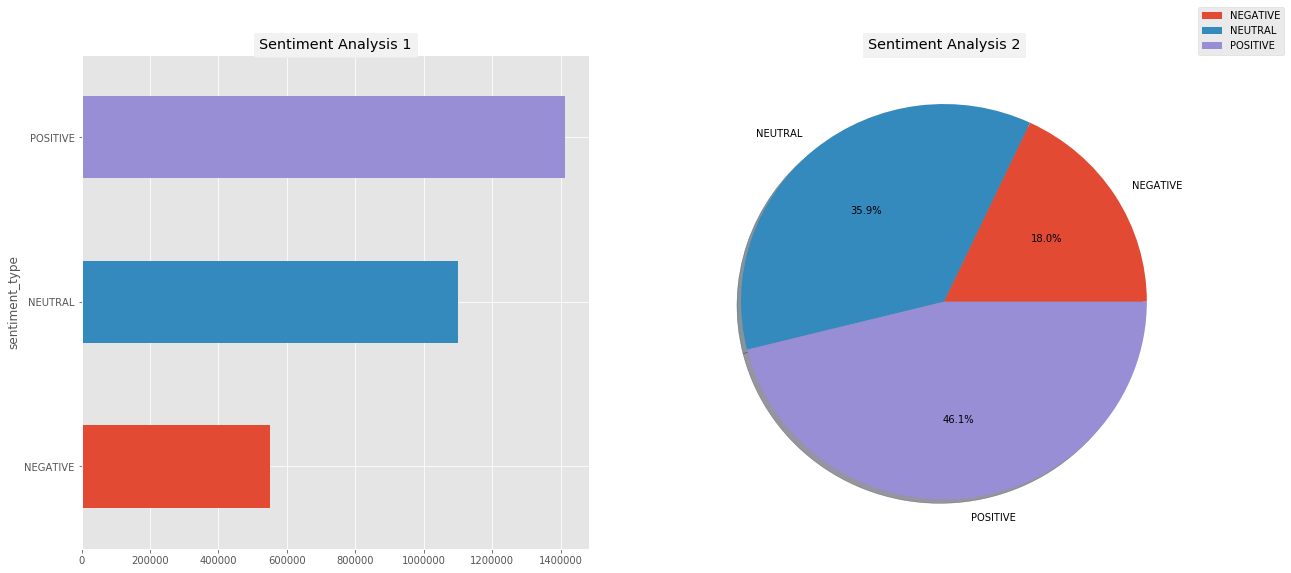

End process at: 2019-08-29 14:35:18.492141
Total time: 0:41:13.893463


In [19]:
# Cleaning, and aggregating of twitter data
try:
    sentiment_df, sentiment_data  = full_text_process(data)
except:
    import datetime
    sentiment_df, sentiment_data  = full_text_process(data)
    
compound = aggregator(sentiment_df)


In [23]:
#Requesting financial data
financials = get_financial_data(symbol='BTCUSDT', start = '1 May 2019', end='1 Aug 2019', interval = '1h')


Retrieving financial data...
Cleaning financial data...
Finished...


In [25]:
# Combine financial and sentiment data (compound and price)
def join_data(sentiment_data, price_data):
    
    sentiment_data = pd.DataFrame(sentiment_data)
    
    combined = pd.merge(price_data, sentiment_data, how='inner', left_on = 'time',right_index = True)
    
    combined = combined.set_index('time')
    
    return combined

final = join_data(compound, financials)
len(final)

2199

In [26]:
final.head()

,close,vol,like,replies,retweets,compound
time,,,,,,
2019-05-01 00:00:00,5335.62,1362.165784,3955,493,743,0.266588
2019-05-01 01:00:00,5338.85,631.481774,1764,380,345,0.225017
2019-05-01 02:00:00,5355.07,1012.867995,1395,312,216,0.264474
2019-05-01 03:00:00,5348.95,1427.585822,1387,223,199,0.274383
2019-05-01 04:00:00,5341.13,512.101053,840,120,155,0.305488


In [27]:
# Save Datasets as JSON files

# financials
financials.to_json('financials.json', orient='records', lines = True, date_format ='iso')

# Aggregated sentiments
final.to_json('aggregated_sentiment.json', orient='columns', date_format ='iso')

# Processed tweets
sentiment_df.to_json('tweets_processed.json', orient='columns', date_format ='iso')
